# **Demo Mapillary API**

Extract **images** from Mapillary dataset random locations on a city, given its latitude and longitude limits

Can also extract a **sequence** of images (i.e. sequence of images along a street provided by Mapillary users)

In [ ]:
!pip install geopandas contextily pyproj tqdm

In [1]:
import requests
from io import BytesIO
from PIL import Image
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as ctx
from pyproj import Transformer

In [ ]:
ACCESS_TOKEN = 'YourAccessToken'

# **Extract images from random locations**

### Latitude & Longitude of the rectangle in which to seek for images

In [3]:
lat_min = 44.4789
lat_max = 44.5141

lon_min = 11.3205
lon_max = 11.3691

### Number of random points

In [4]:
N = 10

In [8]:
points = []

for _ in range(N):
    lat = random.uniform(lat_min, lat_max)
    lon = random.uniform(lon_min, lon_max)

    points.append([lat, lon])

### Acquire images from Mapillary API

It fails $\sim$ 50 % of the times since the image coverage is low

In [9]:
# Delta in ° to search around each random point (0.005 is around 500m)
delta = 0.005

In [ ]:
sequences = []
street_images = []

N_images = 0

for n in tqdm(range(N)):
   
   # Getting the images url
    bbox = f"{points[n][1]-delta},{points[n][0]-delta},{points[n][1]+delta},{points[n][0]+delta}"

    url = "https://graph.mapillary.com/images"
    params = {
        "access_token": ACCESS_TOKEN,
        "fields": "id,sequence,thumb_1024_url,camera_type,computed_geometry,thumb_original_url",
        "bbox": bbox,
        "limit": 1
    }

    try:
        r = requests.get(url, params=params, timeout = 5)
    except requests.exceptions.Timeout:
        continue  
    except requests.exceptions.RequestException as e:
        continue

    images = r.json().get("data", [])    

    for img in images:
        N_images += len(images)

        sequences.append({'id' : img['sequence'], 'coord' : (img['computed_geometry']['coordinates'][0], img['computed_geometry']['coordinates'][1]) } )

        # Extracting the images from urls as numpy array
        try:
            response_image = requests.get(img['thumb_1024_url'], timeout = 5)
        except requests.exceptions.Timeout:
            continue  
        except requests.exceptions.RequestException as e:
            continue

        image_from_url = np.array(Image.open(BytesIO(response_image.content)))

        street_images.append(image_from_url)

print('Found ', N_images, ' images out of ', N)

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

Found  3  images out of  10


Stored in *street_images*

In [ ]:
street_images

### Drawing recovered points on the map

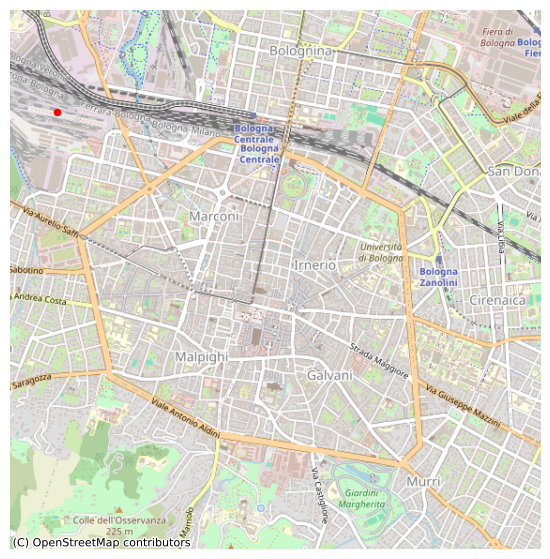

In [44]:
# lat & lon values for drawing Bologna (not necessarily equal the same as before)
lat_min_BO = 44.4789
lat_max_BO = 44.5141

lon_min_BO = 11.3205
lon_max_BO = 11.3691


transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy = True)


x_min, y_min = transformer.transform(lon_min_BO, lat_min_BO)
x_max, y_max = transformer.transform(lon_max_BO, lat_max_BO)


gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy([s['coord'][0] for s in sequences],
                                [s['coord'][1] for s in sequences]),
    crs="EPSG:4326").to_crs(epsg=3857)


fig, ax = plt.subplots(figsize = (7,7))


ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


gdf.plot(ax = ax, marker = 'o', color = 'red', markersize = 20)

ax.axis('off')
plt.show()


# **Getting all the images in a given sequence**

Each sequence can have hundreds of images

In [43]:
# Choose the sequence id from the ones obtained before
n = 0

if n >= len(sequences):
    n = len(sequences) - 1

sequence_id = sequences[n]['id']

In [ ]:
sequence_images = []

url = f'https://graph.mapillary.com/image_ids?access_token={ACCESS_TOKEN}&sequence_id={sequence_id}'

response = requests.get(url)

image_ids = None

if response.status_code == 200:
   # Obtaining all the images id from the sequence
   json = response.json()
   image_ids = [obj['id'] for obj in json['data']]


   for image_id in tqdm(image_ids):

      # Obtaining all the images url of the sequence
      url = f"https://graph.mapillary.com/{image_id}"
      params = {
         "access_token": ACCESS_TOKEN,
         "fields": "id,thumb_1024_url,thumb_original_url,computed_geometry,captured_at"}
      
      try:
         response = requests.get(url, params=params, timeout = 5)
      except requests.exceptions.Timeout:
         continue
      except requests.exceptions.RequestException as e:
         continue

      img_data = response.json()

      # Extracting the images from the sequence as numpy arrays
      try:
            response_image = requests.get(img_data['thumb_1024_url'], timeout = 5)
      except requests.exceptions.Timeout:
         #print(f"Timeout on {url}")
         continue  # salta al prossimo URL
      except requests.exceptions.RequestException as e:
         #print(f"Error on {url}")
         continue

      image_from_url = np.array(Image.open(BytesIO(response_image.content)))

      sequence_images.append(image_from_url)


print('Found ', len(sequence_images), ' images on the sequences out of ', len(image_ids))
     

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]

Found  10  images on the sequences out of  300


Stored in *sequence_images*

In [ ]:
sequence_images